# Exploratory Data and Sentiment Analysis on COVID-19 related Tweets via the TwitterAPI

### Author: George Spyrou
### Date: 26/10/2020

<img src="../img/twitter_sentiment_img.jpg" alt="Sentiment Picture" width="920" height="640">

## Sections

- <a href='#project_idea' style="text-decoration: none">Introduction</a>
- <a href='#data_retrieval' style="text-decoration: none">Part 1: Twitter API and Data Retrieval</a>
- <a href='#data_cleaning' style="text-decoration: none">Part 2: Data Preprocessing and Cleaning</a>
    - <a href='#text_to_df' style="text-decoration: none">Load data from text file into a dataframe</a>
    - <a href='#remove_empty_rows' style="text-decoration: none">Remove rows that contain empty Tweets</a>
    - <a href='#tweet_translate' style="text-decoration: none">Translate non-English Tweets</a>
    - <a href='#remove_punct_and_stopwords' style="text-decoration: none">Remove punctuation and stopwords</a>
- <a href='#main_analysis' style="text-decoration: none">Part 3: Main Analysis</a>
    - <a href='#common_words' style="text-decoration: none">Most common words and bigrams</a>
    - <a href='#geolocator' style="text-decoration: none">Identify geographical location of the Tweets</a>
    - <a href='#sentiment_analysis' style="text-decoration: none">Tweet sentiment anaylsis</a>

<a id='project_idea'></a>
## Project Idea

Purpose of this project is to leverage the TwitterAPI functionality offered by Twitter, and conduct an analysis on tweets that are related with the SARS-CoV-2 virus - or as it's widely known as **COVID-19**. From now on and for an ease of use we will refer to the virus with the latter name, which in reality is the name of the decease. 

Initially, this project started as an exploratory task to learn how the TwitterAPI can be used to retrieve data (tweets) from the web, and how to use the tweepy and searchtweets python packages.

After I managed to retrieve the data, I found myself really interested into digging deeper and get a better understanding of the data and they information they contain. COVID-19 is one of the most discussed topics in Twitter - or any other social media platform - roughly since the virus was first discovered in December of 2019. Because of the nature of this topic, we would expect that people have different opinions - some people feel more scared about the virus, some people do not even believe that the virus exists in the first place. Hence, I thought it would be interesting to see how the **overall** sentinemt of people's opinions about the virus is changing in different time periods during the year.

I believe most people would agree that we are expecting that during the period January 2020 - March 2020, whilst the virus was not widely spread yet, people would not feel afraid and the sentiment would most likely be **neutral**. On the other hand, after April 2020, when most of the countries ended up having a lockdown and the virus became a reality for everyone, we would expect that the sentiment would be more **negative**.

Now before we move further we have to make sure that we understand how we will _measure_ the sentiment and what it means for a Tweet to be **positive**/**neutral**/**negative**. The idea is actually pretty simple, as we will be looking at individual words that tweets consist of and try to understand the sentiment of the tweet as a whole. As a quick example, if a tweet contains words like 'death', 'decease' it's more likely to get a negative sentiment, compared to a tweet containing words like 'cure' and 'healed'.


#### Version 1: The first version has been completed on 01/03/2020 and it includes analysis on:
- Most common words present in tweets.
- Most common bigrams (i.e. pairs of words that often appear next to each other).
- Sentiment analysis by using the Liu Hu opinion lexicon algorithm.
    

<a id="data_retrieval"></a>
## Part 1 - Twitter API and Data Retrieval

At the first part of this project, we are going to deal with setting up the environment required for the analysis, as well as retrieving the data by using the TwitterAPI and leveraging the awesome _searchtweets_ package (https://pypi.org/project/searchtweets/) to connect with the API.

Below I am going to present the script that I have used to get Tweets for different time intervals. At this point it's necessary to mention that I have used the free tier for the TwitterAPI - which of course it's coming with some limitations. One major was the amount of data that I can retrieve per month, as the free tier is providing the following:
1. 25k tweets for the 30day tier (i.e. retrieve data from max 30 days ago from the moment you are making the API call)
2. 5k tweets for the full archive (i.e. retrieve data from any day during the year)

Later in the project we will discuss further about some other limitations of the free tier. Below I am presenting the script that I have used to make the API calls. Please note that this script can not run in a jupyter notebook instance, as it's set up to run from the command line. Either way I chose to present it as it can be useful to see the logic of how to set up the python script to make the API calls.

This script has been formatted in a way that it's trying to get data during different times during the day. I have done this so that we "randomize" the tweets as much as possible, because we wanted to avoid cases where for example we would receive all the data from a Monday morning, where the news/tweets/etc would most probably talk about the same topic.

In [ ]:
import os
import argparse
import json
from datetime  import datetime, timedelta

# Twitter API
from searchtweets import load_credentials
from searchtweets import gen_rule_payload
from searchtweets import ResultStream


# Secure location of the required keys to connect to the API
# This config also contains the search query
json_loc = r'D:\GitHub\Projects\Twitter_Project\Twitter_Topic_Modelling\twitter_config.json'

with open(json_loc) as json_file:
    config = json.load(json_file)

# Project folder location and keys
os.chdir(config["project_directory"])

# Custom functions created for the project
import twitter_custom_functions as tcf

keys_yaml_location = config["keys"]

# Load the credentials to get access to the API
premium_search_args = load_credentials(filename=keys_yaml_location,
                                       yaml_key="search_tweets_api_fullarchive",
                                       env_overwrite=False)
print(premium_search_args)

# Set tweet extraction period 
parser=argparse.ArgumentParser()
parser.add_argument('fromDate', type=str)
parser.add_argument('toDate', type=str)
args = parser.parse_args()

if args.toDate <= args.fromDate:
    print('The date range given is invalid. Please give correct from/to dates')
    exit()

daysList = [args.fromDate]

print(f'Collecting Tweets from: {args.fromDate} to {args.toDate}')

while args.fromDate != args.toDate:
    date = datetime.strptime(args.fromDate, "%Y-%m-%d")
    mod_date = date + timedelta(days=1)
    incrementedDay = datetime.strftime(mod_date, "%Y-%m-%d")
    daysList.append(incrementedDay)
    
    args.fromDate = incrementedDay
    
# Retrieve the data for each day from the API
for day in daysList:
    
    dayNhourList = tcf.create_date_time_frame(day, hourSep=2)
    
    for hs in dayNhourList:
        fromDate = hs[0]
        toDate = hs[1]
        # Create the searching rule for the stream
        rule = gen_rule_payload(pt_rule=config['search_query'],
                                from_date=fromDate,
                                to_date=toDate ,
                                results_per_call=100)

        # Set up the stream
        rs = ResultStream(rule_payload=rule, max_results=100,
                          **premium_search_args)

        # Create a .jsonl with the results of the Stream query
        #file_date = datetime.now().strftime('%Y_%m_%d_%H_%M')
        file_date = '_'.join(hs).replace(' ', '').replace(':','')
        filename = os.path.join(config["outputFiles"],
                                f'twitter_30day_results_{file_date}.jsonl')
    
        # Write the data received from the API to a file
        with open(filename, 'a', encoding='utf-8') as f:
            cntr = 0
            for tweet in rs.stream():
                cntr += 1
                if cntr % 100 == 0:
                    n_str, cr_date = str(cntr), tweet['created_at']
                    print(f'\n {n_str}: {cr_date}')
                json.dump(tweet, f)
                f.write('\n')
        print(f'Created file {f}:')

The script above had to be run *many* times, and each time the output were multiple jsonl files containing the data retrieved for the specified timeframe. Note that the timeframe was usually 2 or 3 days in one call. The reason for that is that there is a **limit** of tweets you can receive in one API call, as well as the number of calls you can make in an hour. 

As you can imagine, the process above has generated hundrends of json files, each one corresponding to a _specific_ time period of a _specific_ day. To make our life easier, we have created a script to merge the raw json files into a single .txt file that will be getting updated every time we receive new day and re-run the script. I am not going to present the code that completes this job here, but if you are interested in it you can find it <a href="https://github.com/gpsyrou/Twitter_Topic_Modelling/blob/master/utilities/merge_json_files.py" alt="link_merge_json" style="text-decoration: none" >here</a>.

<a id="data_cleaning"></a>
## Part 2 - Data Preprocessing and Cleaning

After merging the json file into one single text file which contains all of the data retrieved, we can move to the data preprocessing part of the project. At this point, the data contained in the text file need to be transformed into something that will be handy to work with when we move later to the data analysis part.

To get a better understanding of what's inside the text file, we can imagine that each row represents a different tweet along with a lot of other information, like the date of the tweet, the userid, the tweet itself, the location of the tweet (if any), and many more details.

For the purposes of this project, we will filter the tweets in a way that we will retain only the following attributes:
1. **screen_name**: Corresponds to the username of the person who submitted the tweet
2. **id**: The id of the User
3. **text**: The text representing the tweet. This is the main attribute of our project
4. **location**
5. **created_at**: Date that the tweet was created

Please note that these are only a few of the details that someone could retrieve via the usage of the TwitterAPI. More information about the tweet objects can be found here: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/tweet-object

In [32]:
import pandas as pd
import numpy as np
import pickle
import json
import os
import re
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

json_loc = r'D:\GitHub\Projects\Twitter_Project\Twitter_Topic_Modelling\twitter_config.json'

with open(json_loc) as json_file:
    config = json.load(json_file)

os.chdir(config["project_directory"])

In [6]:
import utilities.twitter_custom_functions as tcf

In [3]:
all_tweets_list_file_loc = r'all_tweets_list.txt'

with open(all_tweets_list_file_loc, 'rb') as file:
    allTweetsList = pickle.load(file)

In [4]:
# Create a dataframe based on the relevant data from the full list of the received tweets
user_ls, userid_ls, tweet_ls = [], [], []
location_ls, datetime_ls, replyto_ls = [], [], []
geo_loc_ls = []

<a id="text_to_df"></a>
Now we will populate the lists that we will use to create the main dataframe of the project. Note that as we are looping through the lists, as the same time we will perform some data cleaning. Specifically we will remove the strings that represent links from the tweets, as they do not provide much information for our analysis.

In [5]:
def remove_url(text: str) -> str:
    """
    Removes URLs (strings that start with 'http\\ or htpps\\) from text
    
    Args:
    ----
        text: Input string the we want to remove the URL from.
     
    Returns:
    -------
    text: The input string clean from any URL.
    """

    regex = r'http[0-9a-zA-Z\\/.:]+.'
    urllinks = re.findall(regex, text)
    if  urllinks != []:
        for url in urllinks:
            print(f'String removed: {url}')
            if type(url) is tuple:
                url = [x for x in url if x != '']
            try:
                text = text.replace(url,'')
            except TypeError:
                continue
        return text
    else:
        pass

In [9]:
for tweet_dict in allTweetsList:
    user_ls.append(tweet_dict['user']['screen_name'])
    userid_ls.append(tweet_dict['user']['id'])
    tweet_ls.append(remove_url(tweet_dict['text']))
    location_ls.append(tweet_dict['user']['location'])
    datetime_ls.append(tweet_dict['created_at'])

String removed: https://t.co/8D9KS9QtnT
String removed: https://t.co/ScympQ4EyA
String removed: https://t.co/jUpbAbZneN
String removed: https://t.co/v56xJekccv 
String removed: https://t.co/2lpVc2LhLX
String removed: https://t.co/JFEgmQ2QeC
String removed: https://t.co/wcjX52Y6PZ
String removed: https://t.co/JFEgmQ2QeC
String removed: https://t.co/6RvFkkkh1o
String removed: https://t.co/jUpbAbZneN
String removed: https://t.co/JFEgmQ2QeC
String removed: https://t.co/uwAqw6CGaq
String removed: https://t.co/NRfi0ivm1i
String removed: https://t.co/bjd8jMghTa
String removed: https://t.co/shIPBhJjbc
String removed: https://t.co/Rsdg0Q3xII
String removed: https://t.co/kvBTObz1MP 
String removed: https://t.co/v1COv3X7HI
String removed: https://t.co/9nestugQQ5
String removed: https://t.co/ADVeFOsPXH
String removed: https://t.co/OamvqqHQhd 
String removed: https://t.co/H6FEH62piX 
String removed: https://t.co/ydDtnWiQT5
String removed: https://t.co/PAFQvwwggS 
String removed: https://t.co/I5gCP1

String removed: https://t.co/QZNM6yAJRp
String removed: https://t.co/du0kNdwGFO
String removed: https://t.co/aJsvIddwW5
String removed: https://t.co/rEDiHmQ9EC
String removed: https://t.co/IYpCC0nhZV 
String removed: https:/…
String removed: https://t.co/YzcRsaHfIl
String removed: https://t.co/kjK74VX7FT
String removed: https://t.co/jwLEn…
String removed: https://t.co/tgINAdhDT7 
String removed: https://t.co/xQ8z2ihrAu
String removed: https://t.co/RC1Yzolcwj 
String removed: https://t.co/Fqq3aMfTe4
String removed: https://t.co/wtnzDlql5W
String removed: https://t.co/94vo2HIXMD
String removed: https://t.co/zEDkrzGSZd
String removed: https://t.co/wSnzVUuiG4
String removed: https://t.co/lJxxGCK4A1
String removed: https://t.…
String removed: https://t.co/zznjFIel6Y
String removed: https://t.co/l6gGmjil7T
String removed: https://t.co/Q1Hm7dNVsv
String removed: https://t.co/68ygCALNBs
String removed: https://t.co/lY2smnpgSz
String removed: https://t.co/xQ8z2ihrAu
String removed: https://t.co

String removed: https://t.co/TWfV2MowZM
String removed: https://t.co/ckirR61yGm 
String removed: https://t.co/duzc…
String removed: https://t.co/CAnatOgtBE
String removed: https://t.co/A1aokzLdsM
String removed: https://t.co/d4D1evKs9j
String removed: https://t.co/9QQdNIE6f6
String removed: https://t.co/ElK5erJPzQ
String removed: https://t.co/0FGtKK4zjD
String removed: https://t.co/lpxqnw1RXX
String removed: https://t.co/sf5PAfFK…
String removed: https://t.co/4cywNFOptl
String removed: https://t.co/eUoE2b20hL
String removed: https://t.co/bxh…
String removed: https://t.co/5awWyeG3u8
String removed: https://t.co/AY7EQoumpW
String removed: https://t.co/ecr4EPmrNO 
String removed: https://t.co/ny87pkNKJg
String removed: https://t.co/9QQdNIE6f6
String removed: https://t.co/QUK26IC85b
String removed: https://t.co/cdCT6OvCZc
String removed: https://t.co/EuMc9xGpHW 
String removed: https://t.co/4Wp7sty5Pe
String removed: https://t.co/aZoKJ9fetq
String removed: https://t.co/txuHiI2Ob3
String re

String removed: https://t.co/LpM1yrYphS
String removed: https://t.co/fWbVuTbblt 
String removed: https://t.co/BYKwxWw8Gb
String removed: https://t.co/O39HTF8ogL
String removed: https://t.co/Ur51G9mcQV
String removed: https://t.co/wH9KJH9uBz
String removed: https://t.co/UCIgKNCc7G 
String removed: https://t.co/l5hjMt91Wf 
String removed: https://t.co/YWJuLpjLTa
String removed: https://t.co/lV1jvEYszV
String removed: https://t.…
String removed: https://t.co/ydmX8SeGqJ
String removed: https://t.co/4YO5dGUA1i
String removed: https://t.co/uq7LjpQqd2
String removed: https://t.co/hUcFnzmWzr
String removed: https://t.co/NI9YmEyp…
String removed: https://t.co/xZO7EF1G6p
String removed: https://t.co/uWVKHWlklO 
String removed: https://t.co…
String removed: https://t.co/E4rVqyRrm1
String removed: https://t.co/TUYNi1ZJsQ
String removed: https://t.co/AmRf5mTO21
String removed: https://t.co/0B5ANcNlod
String removed: https://t.co/ZKDsr8wcRj
String removed: https://t.co/lK1IBhkkWV
String removed: htt

String removed: https://t.co/4I2HewHHNW 
String removed: https://t.co/eAbFyyoe…
String removed: https://t.co/swZhzDVedQ 
String removed: https://t.co/XpNWHbamMI
String removed: https://t.co/99u8QwRsvS
String removed: https://t.co/mK4BW3fyDx 
String removed: https://t.co/ANfQKLZfnT
String removed: https://t.co/leae9TTZqe
String removed: https://t.co/F3fJkS4gfX 
String removed: https://t.co/squAOjDm4B
String removed: https://t.co/F1BilE2HP5
String removed: https://t.co/jGjsN92Yab
String removed: https://t.co/JwtyFgL23h
String removed: https://t.co/U2iPkeuGBD
String removed: https://t.co/jS32hKp4LZ 
String removed: https://t.co/0zMcDdlh6P
String removed: https://t.co/eAaDF4jxK7
String removed: https://t.co/gWdmeCbwLH
String removed: https://t.co/IdSHU4AoQQ 
String removed: https://t.co/cMd6XWawdg
String removed: https://t.co/9chCqxkSVs
String removed: https://t.co/kBxHW9f8JH
String removed: https://t.co/kE37LgZObm
String removed: https://t.co/ntDAFgpgzn 
String removed: https://t.co/S…
St

String removed: https://t.co/XEslkKU73u 
String removed: https://t.co/eeQo8p167a
String removed: https://t.co/aU36Ji6IvZ
String removed: https://t.co/c8MoTkTGpx
String removed: https://t.co/pMiwqSUT1A 
String removed: https://t.co/rnrAP5kGU6
String removed: https://t.co/FrAYNLDkKU 
String removed: https://t.co/lrcBY1j2f9
String removed: https://t.co/8ZpqU1Csuz
String removed: https://t.co/WvunKxoIkr
String removed: https://t.co/w8WeYe49IS
String removed: https://t.co/vU6jqt7Ct0
String removed: https://t.co/8d6gAbLE1n
String removed: https://t.co/qB32SFpa8n
String removed: https://t.co/RCvToL2Qwi
String removed: https://t.co/8ZpqU1Csuz
String removed: https://t.co/CdNCdPvIuC 
String removed: https://t.co/4nn5NmrQcU 
String removed: https://t.co/bQwFFkTN5v
String removed: https://t.co/YXAvRgQvDs
String removed: https://t.co/O0T…
String removed: https://t.co/uOkdbRPcl2
String removed: https://t.co/ih5Zr0Grxg
String removed: https://t.co/azicQ8ttbx
String removed: https://t.co/YRQ8OY20Is 


String removed: https://t.co/eGen7PjArX 
String removed: https://t.co/JSuhc0A766
String removed: https://t.co/s9kxroRDTz 
String removed: https://t.co/UemhdtIha1
String removed: https://t.co/oINWE49vVl
String removed: https://t.co/nqsFe3rlYg
String removed: https://t.co/OK9TJSvOSy
String removed: https://t.co/riTYMq1lRq 
String removed: https://t.co/NKHy2ZJ4H7
String removed: https://t.co/QluYIPoiiK
String removed: https://t.co/cBsYQ99OWJ 
String removed: https://t.co/7k4uhnIaaj
String removed: https://t.co/IgsPCuWGXL 
String removed: https://t.co/w39gmoVB4V
String removed: https:…
String removed: https://t.co/31XuXH72Vi
String removed: https://t.co/Hu6rOHvo6K
String removed: https://t.co/OCNYM4xcXn
String removed: https://t.co/jsBpTlIkSo
String removed: https://t.co/r…
String removed: https://t.co/Bf3wL7QRPk
String removed: https://t.co/mnBrrb07cx 
String removed: https://t.co/PGqV72Nz05
String removed: https://t.co/FUxRvXgJcc
String removed: https://t.co/EJbHgZjXEM
String removed: ht

String removed: https://t.co/u7a7h8BiY0 
String removed: https://t.co/37X8K53JbR
String removed: https://t.co/I2w…
String removed: https://t.co/vgSIZB2zbu
String removed: https://t.co/sqBLzXcUyG
String removed: https://t.co/DcbLa7ye71
String removed: https://t.co/2BjO7bodNx
String removed: https://t.co/yzgs8g1lM3
String removed: https://t.…
String removed: https://t.co/BvtjsueWdb
String removed: https://t.co/IqjoIiT7wR
String removed: https://t.co/HqfUxrf23n
String removed: https://t.co/0G6Cdvjtsh
String removed: https://t.co/ahVbxpnUfX 
String removed: https://t.co/suFCG6p0oV
String removed: https://t.co/vSYQPxjpvO
String removed: https://t.co/rm5FP9foR3
String removed: https:/…
String removed: https://t.co/T15m888P5h
String removed: https://…
String removed: https://t.co/Hu731uIo7F
String removed: https://t.co/1EeYGPYaHi
String removed: https://t.co/0P8tMCFjvz 
String removed: https://t.co/6VKd…
String removed: https://t.co/bx7xmABZZd
String removed: https://t.co/cA8PnvGqXf
String re

String removed: https://t.co/q3AGwP…
String removed: https://t.c…
String removed: https://t.co/QbI7VeODFi?
String removed: https://t.co/Gr61drzaqe
String removed: https://t.co/tsntIGk5gn
String removed: https://t.co/XLFmLlfPXH
String removed: https://t.co/eZh2NZP9rM
String removed: https://t.co/MbGtzDFC1H
String removed: https://t.co/hac6US9A10
String removed: https://t.co/FZtUDLwZQA
String removed: https://t.co/V1Puau1CAw
String removed: https://t.co/cCpuho9nza 
String removed: https://t.co/q2dG66kzoR
String removed: https://t.co/jWDCv…
String removed: https://t.co/vDYmOTZptf
String removed: https://t.co/XGBPHWwCku
String removed: https://t.co/V1Puau1CAw
String removed: https://t.co/Kv586jroXz
String removed: https://t.co/n5GcgLzb2d
String removed: https:/…
String removed: https://t.co/LS9Zc8uu1B
String removed: https://…
String removed: https://t…
String removed: https://t.co/19XcZqd7sq
String removed: https://t.co/JkUFQ…
String removed: https://t.co/V1Puau1CAw
String removed: https:

String removed: https://t.co/ANG…
String removed: https://t.co/LLry9urKkz
String removed: https://t.co/emzZleEXZO
String removed: https://t.co/FAh7GVLXJf
String removed: https://t.co/Q6vFPaSKoD
String removed: https://t.co/hm2JzIBrah
String removed: https://t.co/7SrpL2KYC1
String removed: https://t.co/RPBnVGiPid
String removed: https://t.co/EkHsUAWTAU
String removed: https://t.co/PwRC2XOPm3
String removed: https:/…
String removed: https://t.co/rsKnzgkY2p 
String removed: https://t.co/tCH9G4NwZI
String removed: https://t.co/0uGl30U8oB
String removed: https://t.co/tdRieYfGUs
String removed: https://t.co/ylL1VrLArn
String removed: https://t.co/oE9zNmSPTf
String removed: https://t.co/1T7T2itObB
String removed: https://t.co/1Y2c4uSH4d
String removed: https://t.co/B8qka6yOVG
String removed: https://t.co/ur9slUbbfg
String removed: https://t.co/WVxsq1…
String removed: https://t.co/V2pwalXZ5n
String removed: https…
String removed: https://t.co/ssd6H2O3RU
String removed: https://t.co/QaPJeBScSf


String removed: https://t.co/IArHxRq…
String removed: https://t.co/IArHxRq…
String removed: https://t.co/MNdmzOHPE3
String removed: https://t.co/ryBQabbKHt
String removed: https://t.co/dRK2EtIgLv
String removed: https://t.co/28S1vp9b6K
String removed: https://…
String removed: https://t.co/pLtT2zXu…
String removed: https://t.co/z0El5HjDFg
String removed: https://t.co/RZgfY4aBYW
String removed: https://t.co/2K35MAn7Pd
String removed: https://t.co/3Bm7nAeLH7
String removed: https://t.co/8sd23dbmt5
String removed: https://t.co/BFxAS9tYBU
String removed: https://t.co/lolaltYhH4
String removed: https://t.co/Vh5JnfAW6b
String removed: https:…
String removed: https://t.co/22EJKh8Mf4
String removed: https://t.co/doACxkAE8R
String removed: https://t.co/MHSFcJzyGa
String removed: https://t.co/2ME…
String removed: https://t.co/db36YPNcmA
String removed: https://t.co/bxb56tZkpA
String removed: https://t.…
String removed: https://t.co/StaMbkeI7U
String removed: https://t.co/GZ4efWC9OY
String remove

String removed: https://t.co/GdVkLHhGhJ
String removed: https://t.co/KyzfOyI17s
String removed: https://t.co/JZ8z7QT0c2
String removed: https://t.co/3LcNhzXL8t
String removed: https://t.co/1s0pylngma
String removed: https://t.co/fYNq7d0qtz 
String removed: https://t.co/Ap2wGc…
String removed: https://t.co/eFteoWR26E
String removed: https://t.co/mpaXpAjFh9
String removed: https://t.co/KJMewxyQG4
String removed: https://t.co/GV6DAg3q3N
String removed: https://t.co/cBODm3hfSa
String removed: https://t.co/A6GKSlfNdz
String removed: https://t.co/060hTDDBqH
String removed: https://t.co/Hi7UVQBpJh 
String removed: https://t.co/MwxtbYIj2h
String removed: https://…
String removed: https://t.co/z09bFvNOln
String removed: https://t.co/L7cdcpjysp
String removed: https://t.co/TYOTzATZ6O
String removed: https://t.co/3W4bHTfPmv
String removed: https://t.co/YpzAlSFTZV
String removed: https://t.co/PWvWNt3mCM
String removed: https://t.co/6uIWvdArfa
String removed: https://t.co/A0EH41rjuG
String removed:

String removed: https://t.co/hgW0NrVUf5
String removed: https://t.…
String removed: https://t.co/vGvbYOOAk8
String removed: https://t.co/wbv3RicEpD
String removed: https://t.co/0cI7Du3Lpy
String removed: https://t.co/i8oanJw07b
String removed: https://t.co/sIt6zUNv98
String removed: https://t.co/QgvbBwcg7Z
String removed: https://t.co/QgvbBwcg7Z
String removed: https://t.co/eTgLNr0D2O
String removed: https://t.co/pQ7VuaLfua
String removed: https://t.co/s48m7CbT8B
String removed: https://t.co/e5gxAKA8Ia
String removed: https://t.co/gEtwCh67w1
String removed: https://t.co/9qaanECqpE
String removed: https://t.co/vOVkrNW2Ww
String removed: https://t.co/UrMyYwsVeu
String removed: https://t.co/oBA5nUCFTr
String removed: https://t.co/UrMyYwsVeu
String removed: https://t.co/1cvbKa28oA
String removed: https://t.co/P9hTr8ee27
String removed: https://t.co/6hANU16Gsn
String removed: https://t.co/JWbD7SAqHL
String removed: https://t.co/NzCREhYt8c
String removed: https://t.co/9Lpmz9ED5O
String remov

String removed: https://t.co/lyzdsBwgI4
String removed: https://t.co/jnJSPoIKFj
String removed: https://t.co/F7GcosfFb4
String removed: https://t.co/YU1vT8IUD1
String removed: https://t.co/6Che3daRP0
String removed: https://t.co/CLUlC8UKn9
String removed: https://t.co/5zcqeNtrze
String removed: https://t.co/4KGgd0yKUY
String removed: https://t.co/fq4b7kdBem
String removed: https://t…
String removed: https://t.co/qWMzvUgb6v
String removed: https://t.co/VKU0xPiaYq
String removed: https://t.co/i3sDuoBKtq
String removed: https://t.co/PVoyrR7BBC
String removed: https://t.co/1GuGxH4pr7
String removed: https://t.co/LLYWnCmtTv
String removed: https://t.co/FMyb007oxA
String removed: https://t.co/pY9p4iIgxb
String removed: https://t.co/8sllf…
String removed: https://t.co/vjt5eHHPEv
String removed: https://t.co/AGXwz5gCzh
String removed: https://t.co/eyG7IwWYw7
String removed: https://t.co/pACSXsNU8u
String removed: https://t.co/i…
String removed: https://t.co/5PZatMJ38K
String removed: https://t

String removed: https://t.co/Fcz3bj0dOQ
String removed: https://t.co/F7UBE5MHeA
String removed: https://t.co/B5BAz4TntS
String removed: https://t.co/wyfJFVwoYx
String removed: https://t.co/p0…
String removed: https://t.co/ffUeqDMvZ2
String removed: https://t.co/KKytMirKsY
String removed: https://t.co/yiCGZu17tF
String removed: https://t.co/vUVJ…
String removed: https://t.co/i4btySMi6T
String removed: https://t.co/08Vc0hzX…
String removed: https://t.co/ooit86EGG9
String removed: https://t.co/hEQWOA75rv
String removed: https://t.co/…
String removed: https://t.co/arPBw1XFzB
String removed: https://t.co/NFsSCGNISU
String removed: https://t.co/ooit86EGG9
String removed: https://t.co/m69od7ldPB
String removed: https://t.co/p0…
String removed: https://t.co/R9Qns7dTLQ
String removed: https://t.co/7uA6A1InfG
String removed: https://t.co/IxXjcrDLEL
String removed: https://t.co/nYl8irm18X
String removed: https://t.co/UOnUw38YuD
String removed: https://t.co/gxNze7S…
String removed: https://t.co/am

Finally, we can create the first version of the main dataframe:

In [10]:
tweets_df = pd.DataFrame(list(zip(user_ls, userid_ls, tweet_ls, location_ls, datetime_ls)),
                  columns=['Username', 'UserID', 'Tweet', 'Location', 'Date'])

In [11]:
tweets_df.head(10)

,Username,UserID,Tweet,Location,Date
0,dt_next,3991108098,The government has issued a travel advisory as...,"Chennai, India",Fri Jan 17 11:59:45 +0000 2020
1,gomez_grandes,1136279013763289088,RT @gomez_grandes: #Cuba China registra una se...,None,Fri Jan 17 11:59:40 +0000 2020
2,fredygu1,46778936,None,Monterrey,Fri Jan 17 11:59:30 +0000 2020
3,AndriuAlanoca,614513903,None,Chile,Fri Jan 17 11:59:28 +0000 2020
4,ginniasa,77748386,None,"Puerto Montt, Chile",Fri Jan 17 11:59:24 +0000 2020
5,nonatdexlol,843601394183651328,None,riverdale barn,Fri Jan 17 11:59:24 +0000 2020
6,Zeokon,1970523644,None,None,Fri Jan 17 11:59:14 +0000 2020
7,malena1083,796893205925076992,None,"Guayaquil, Ecuador",Fri Jan 17 11:59:11 +0000 2020
8,supriyabez,206092315,None,Delhi,Fri Jan 17 11:58:57 +0000 2020
9,ommzk,229737319,RT @MailOnline: Thailand announces a SECOND ca...,ToxiCity:,Fri Jan 17 11:58:52 +0000 2020


By taking a look at the main column of interest for this project (i.e. 'Tweet') we can see that there are many cases where a Tweet was blank. This might have happened due to a tweet that was just a repost from another tweet or the tweet contained only a link - which would have been removed from the previous step. The TwitterAPI has an option to filter out empty tweets when retrieving the data, but unfortunately it's not something that it's being offered in the free tier that we are using for this project.
<a id="remove_empty_rows"></a>
#### Removing empty rows

Hence, we are going to remove the lines that do not contain a tweet as they do not provide any useful information for this project.


In [13]:
print('Number of lines before removing empty tweets: {0}'.format(tweets_df.shape[0]))

Number of lines before removing empty tweets: 102404


In [16]:
tweets_df = tweets_df[tweets_df['Tweet'].notnull()].reset_index()
tweets_df.drop(columns=['index'], inplace=True)

print('Number of lines before removing empty tweets: {0}'.format(tweets_df.shape[0]))

Number of lines before removing empty tweets: 36492


At the next step we will use the 'Date' column to extract the Year and Month, as they are going to be used later in the project.

In [15]:
tweets_df['Year'] = pd.DatetimeIndex(tweets_df['Date']).year
tweets_df['Month'] = pd.DatetimeIndex(tweets_df['Date']).month

tweets_df.head(5)

,Username,UserID,Tweet,Location,Date,Year,Month
0,dt_next,3991108098,The government has issued a travel advisory as...,"Chennai, India",Fri Jan 17 11:59:45 +0000 2020,2020,1
1,gomez_grandes,1136279013763289088,RT @gomez_grandes: #Cuba China registra una se...,None,Fri Jan 17 11:59:40 +0000 2020,2020,1
2,ommzk,229737319,RT @MailOnline: Thailand announces a SECOND ca...,ToxiCity:,Fri Jan 17 11:58:52 +0000 2020,2020,1
3,CTV_AvisFavaro,24185568,RT @CTVNews: China reports second death in cor...,Toronto,Fri Jan 17 11:58:51 +0000 2020,2020,1
4,supriyabez,206092315,RT @WHO: Reduce your risk of #coronavirus infe...,Delhi,Fri Jan 17 11:58:36 +0000 2020,2020,1


In [ ]:
tweets_df['Tweet_Translated'] = tweets_df['Tweet'].apply(lambda text:
                                                    tcf.translate_tweet(text))

<a id="tweet_translate"></a>
#### Translate non-English Tweets

There are many cases where the retrieved tweet is not in English. Therefore we are going to utilize the  <a href="https://pypi.org/project/googletrans/" style="text-decoration: none">googletrans</a> Python package and the Google API to automate this task.

In [17]:
def translate_tweet(text: str) -> str:
    """
    If Tweets are written in any other language than English, translate to
    English and return the translated string.
    """
    translator = Translator(service_urls=['translate.google.com'])
    language_detected = translator.detect(text)
    if language_detected.lang != 'en':
        print(text)
        try:
            textTranslated = translator.translate(text, dest='en').text
        except json.JSONDecodeError:
            textTranslated = text
            pass
    else:
        textTranslated = text
    return textTranslated

In [ ]:
tweets_df['Tweet_Translated'] = tweets_df['Tweet'].apply(lambda text: translate_tweet(text))

The final step of the initial data cleaning and preprocessing is to clean the tweets from any punctuation (e.g. '.', '!'),  numbers or stopwords. 

Stopwords are common words used in a language that do not provide much information in a sentence. A few examples of words like these are 'the', 'a', etc

<a id="remove_punct_and_stopwords"></a>
#### Remove punctuation, stopwords and numbers

In [20]:
def remove_punct_and_stopwords(text: str, stopwordlist: list,
                               num_list: list) -> str:
    """
    Given text, remove stopwords and punctuation from the string and convert
    all characters to lowercase.
    
    Args:
    ----
    text : str
            Input text for cleaning.
    stopwordlist: list
            List of stopwords to be removed from the string.
    num_list: list
            List of number to be removed from the string.
    
    Returns:
    -------
    text: str
        The input string as lowercase, clean from stopwords/punctuation/numbers
    """

    tknzr = TweetTokenizer()
    try:
        txt_tokenized = tknzr.tokenize(text)
        text = ' '.join([char.lower() for char in txt_tokenized if char.lower() 
                         not in string.punctuation and char.lower() not in
                         stopwordlist and char not in num_list])
    except TypeError:
       pass
   
    return text

In [21]:
stopwords_full = list(stopwords.words('english'))
spanish_stopwords = list(stopwords.words('spanish'))

# Remove common words or punctuation used in tweets plus the term that we used for the query
commonTwitterStopwords = ['rt', 'RT', 'retweet', 'new', 'via', 'us', 'u', 'covid', 'coronavirus', '2019', 'coronavírus',
                          '#coronavirus', '19', '#covid', '#covid19','#covid2019', '…', '...', '“', '”', '‘', '’']

stopwords_full.extend(commonTwitterStopwords + spanish_stopwords)
num_list = '0123456789'

In [ ]:
tweets_df['Tweets_Clean'] = tweets_df['Tweet_Translated'].apply(
        lambda x: tcf.remove_punct_and_stopwords(x, stopwords_full, num_list))

Please note that the process above is very time consuming as we are making multiple calls to the Google API, one for each line of the dataframe. 

In order to avoid rerunning this every time, we will just import the latest version of the file that contains the translated tweets:



In [7]:
translated_tweets_filename = 'tweets_translated.csv'

In [ ]:
tweets_df.to_csv(translated_tweets_filename, sep='\t', encoding='utf-8', index=False)

In [8]:
tweets_df = pd.read_csv(translated_tweets_filename, sep='\t', encoding = 'utf-8', index_col=[0])

tweets_df = tweets_df[tweets_df['Tweets_Clean'].notnull()].reset_index()

Before we move to the main analysis, we can have a quick look to identify how many tweets we have per year/month:

There is a total of 23628 tweets in the dataset


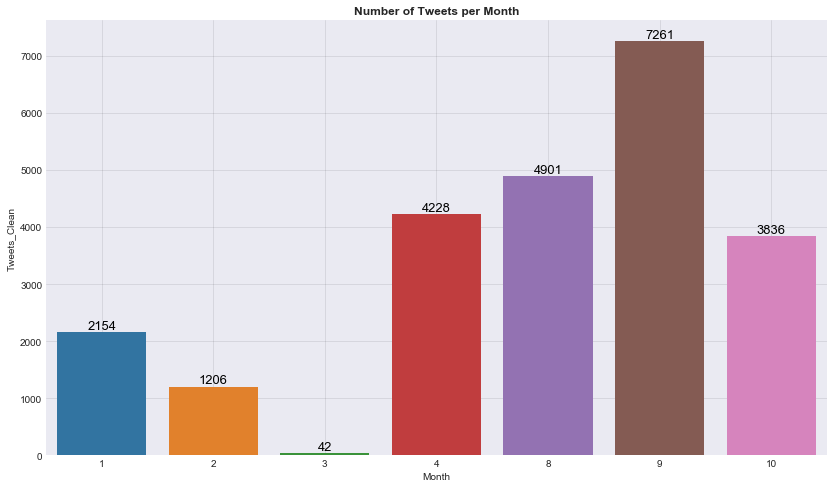

In [9]:
# Barplot 
plt.figure(figsize=(14, 8))
tweets_per_month = tweets_df.groupby('Month')['Tweets_Clean'].count().reset_index()
bar_plot = sns.barplot(x='Month', y='Tweets_Clean', data=tweets_per_month)
for p in bar_plot.patches:
             bar_plot.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 6), textcoords='offset points')
plt.title('Number of Tweets per Month', fontweight='bold')
plt.grid(True, alpha=0.1, c='black')

#Total
print('There is a total of {0} tweets in the dataset'.format(tweets_df['Tweets_Clean'].count()))

<a id="main_analysis"></a>
## Part 3 - Main Data Analysis of Tweets

At this stage we have successfuly collected the data of interest, merged them into a single file, created a dataframe and performed some common text preprocessing techniques like translating the text to English, remove punctuation and stopwords and more.

Therefore, we are now in a position to start the main part of this project. We will attempt to investigate how the public sentiment is changing regarding the virus across different months. In order to avoid repeating the code or making it hard to read, we have implemented a custom Class which we will use for the main analysis. The code that contains the class and it's methods can be found <a href="https://github.com/gpsyrou/Twitter_Topic_Modelling/blob/master/sentiment_class.py" style="text-decoration: none">here</a>. Please make sure to have this link open if you want to understand what is the code used for each of the following steps.

In [10]:
from sentiment_class import TwitterSentiment, month_as_string

<a id="common_words"></a>
### Identify the most common word and bigrams

At first we will explore the public sentiment and most common words/bigrams used in tweets across the whole dataset. Of course some of our results will be skewed depending on the amount of data that we have for each month, but investigating the overall case is useful to see what words people use in their tweets independently of how much familiar they are with the virus. 

For example, during the first few months of the virus (January-April) we would expect the tweets to be more targeted to the virus per se, tweeting about the number of cases/deaths, etc. On the other hand, when people familiarize themselves more with the virus, we would expect that the conversations might swift to other topics, like what political implications the virus has for specific countries, what are the advancements related to a vaccine and more.


**Overall:**

In [11]:
tweets_all_months = TwitterSentiment(input_df=tweets_df, tweet_column='Tweets_Clean')

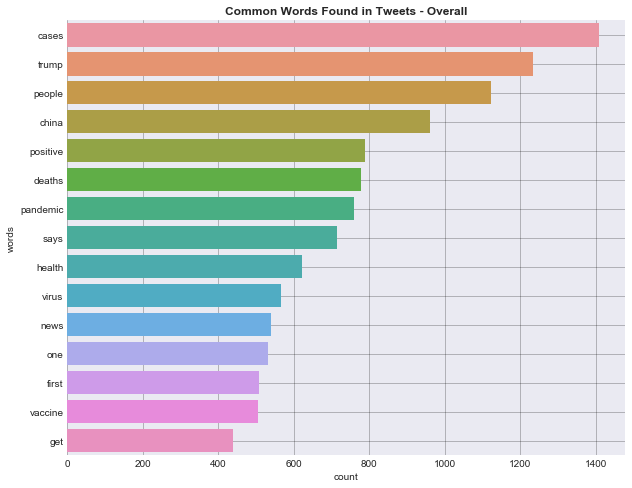

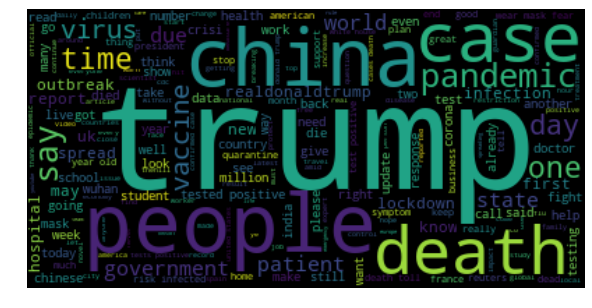

In [24]:
tweets_all_months.plot_most_common_words(n_most_common=15, figsize=(10, 8))

tweets_all_months.plot_wordcloud(figsize=(10, 8))

We can see that for the overall case, people tend to use the word 'cases' a lot - most likely due to regular updates of new cases of the virus each day. Interesting is that in the second place we can see that is 'Trump' - indicating that people tend to tweet include the name of the American president in the tweets that are related to COVID19. The latter one could also be the case, if the tweets that we have received are coming mainly from the USA, which is something that we will analyze later in the project. 

Now we can also see what are the most common bigrams across all the tweets received:

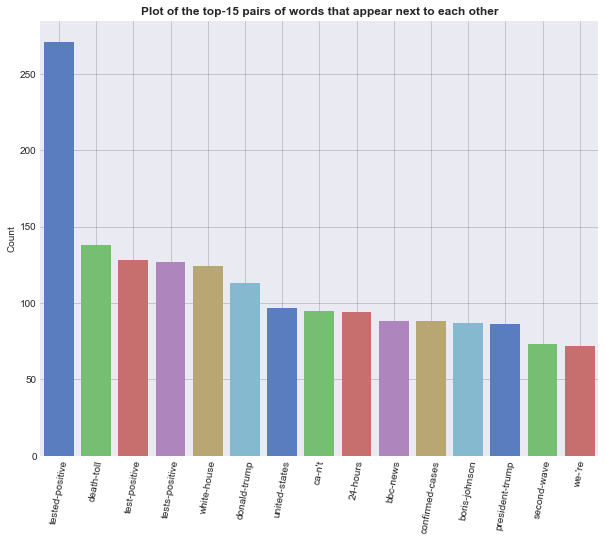

In [26]:
bigrams_all = tweets_all_months.compute_bigrams()
tweets_all_months.plot_bigrams(top_n=15, figsize=(10, 8))

We can see similar patterns when analyzing the bigrams. The majority of the bigrams are related to the trajectory of the virus (i.e. positive cases identified, number of deaths, etc), as well as bigrams connected to the US (white-house, donald-trump, president-trump). 

**April 2020:**

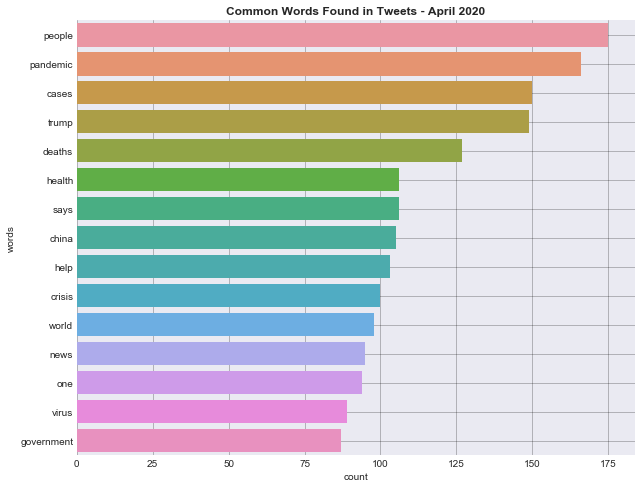

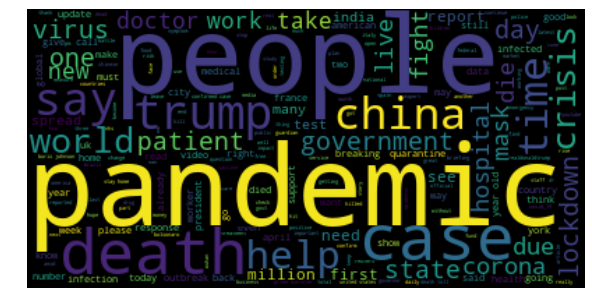

In [22]:
tweets_april = TwitterSentiment(input_df=tweets_df, tweet_column='Tweets_Clean')

tweets_april.subset_dataframe(year=2020, month=4)

tweets_april.plot_most_common_words(n_most_common=15, figsize=(10, 8))

tweets_april.plot_wordcloud(figsize=(10, 8))

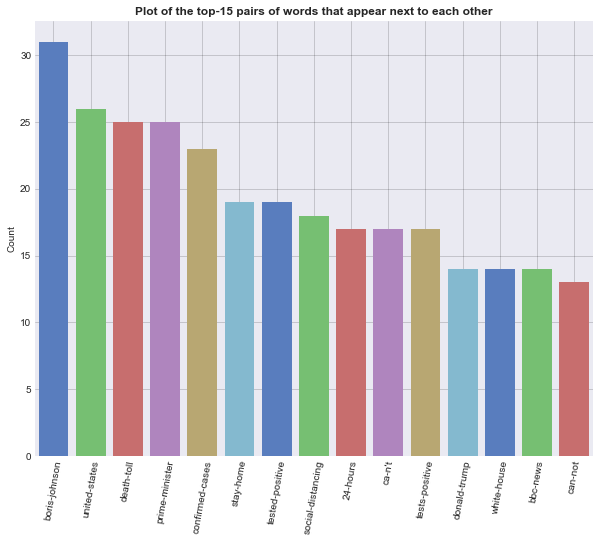

In [27]:
bigrams_april = tweets_april.compute_bigrams()
tweets_april.plot_bigrams(top_n=15, figsize=(10, 8))

By looking at the April results, which was the month that most of the countries around the world were getting into a lockdown and the virus was still something unfamiliar for most of the people, we can observe the tendency of using words related to the new 'normal'. We can see that words like 'health', 'death', 'crisis', 'pandemic' are scoring really high in our analysis.

**August 2020:**

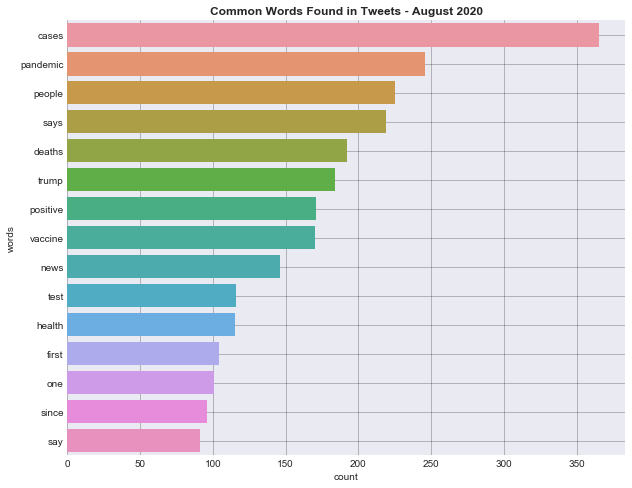

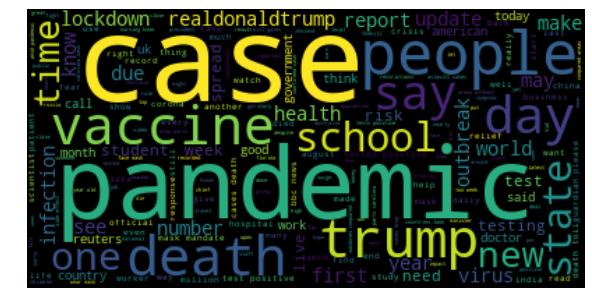

In [28]:
tweets_august = TwitterSentiment(input_df=tweets_df, tweet_column='Tweets_Clean')

tweets_august.subset_dataframe(year=2020, month=8)

tweets_august.plot_most_common_words(n_most_common=15, figsize=(10, 8))

tweets_august.plot_wordcloud(figsize=(10, 8))

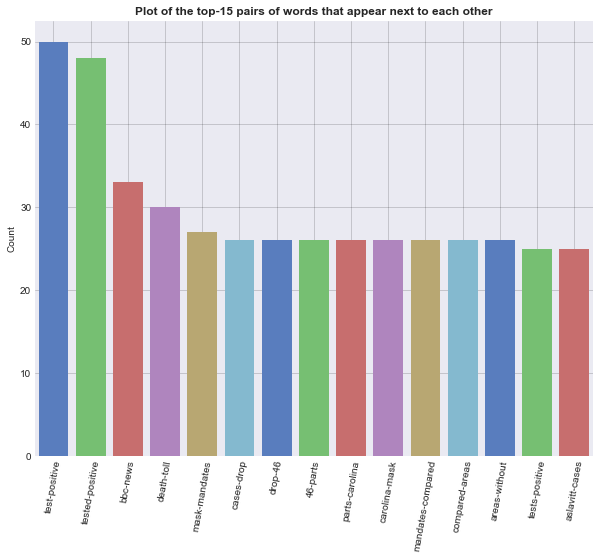

In [29]:
bigrams_august = tweets_august.compute_bigrams()
tweets_august.plot_bigrams(top_n=15, figsize=(10, 8))

In the August data we can see how the word "mask" starting being used more across the tweets - which is something expected as August is a month that many countries around the world made mask covering as a mandatory measure to restrict the spread of the virus. 

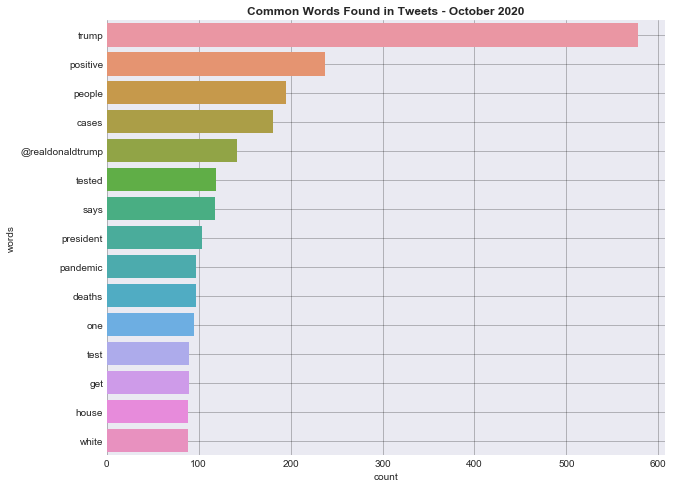

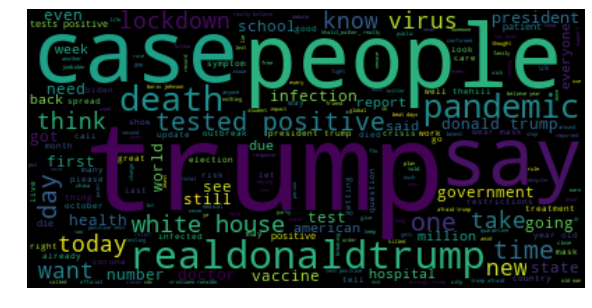

In [30]:
tweets_october = TwitterSentiment(input_df=tweets_df, tweet_column='Tweets_Clean')

tweets_october.subset_dataframe(year=2020, month=10)

tweets_october.plot_most_common_words(n_most_common=15, figsize=(10, 8))

tweets_october.plot_wordcloud(figsize=(10, 8))

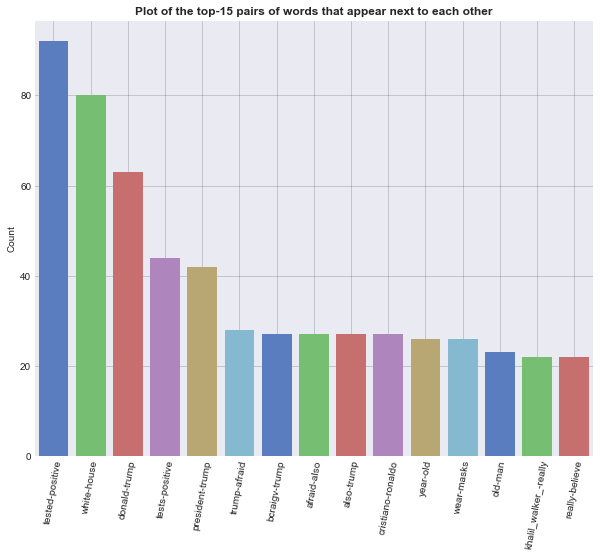

In [31]:
bigrams_october = tweets_october.compute_bigrams()
tweets_october.plot_bigrams(top_n=15, figsize=(10, 8))

In the October data we can observe how extented is the usage of the word 'Trump', which can be due to the fact that the American president caught the virus early in October 2020. Another possible explanation might be the fact that the American elections of 2020 are relatively close to this month. Finally we can see the name of Cristiano Ronaldo mentioned many times during this month, which could also be because he diagnosed positive at some point during the month of October.

<a id="geolocator"></a>
### Geolocation of Tweets

Apparently from the results above we can see that there is a tendency for the Tweets to refer to president Trump or the United States in general. That could be because the data that we have retrieved from the API were coming from inside the United States. Unfortunately the free tier of the API does not give us the option to speficy an exact country/location that we want to retrieve data from, so in some way the tweets retrieved are "random".

Hence, we have decided to leverage the <a href="https://geopy.readthedocs.io/en/stable/" style="text-decoration: none">geopy</a> API to attempt and identify where all these tweets are coming from. We are going to use this API along with the 'Location' column from our dataframe and try to infer the location of the tweet by the 'Location' field (if populated).

Currently the **Location** in the dataframe looks as below:

In [33]:
tweets_all_months.df['Location'].head(10)

0                Chennai, India
1                           NaN
2                     ToxiCity:
3                       Toronto
4                         Delhi
5    Stuttgart, München, Berlin
6                  New York, NY
7                           NaN
8                 United States
9               United Kingdom 
Name: Location, dtype: object

By using the geopy API, we will retrieve the corresponding Longitude and Latitude values for each element that contains a valid location. If there is no valid location or we couldn't locate it for any reason, we will just skill this element and move to the next one. With this exercise we don't want to get a 100% accurate depictions of where the tweets are coming from, but mainly just get an understanding of the locations that we have retrieved data from.

In [63]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut

import utilities.plot_world_map as pmap

geolocator = Nominatim(user_agent="https://developer.twitter.com/en/apps/17403833") 
   
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1, max_retries=3, error_wait_seconds=2)

In [67]:
def get_valid_coordinates(location: str, geolocator: Nominatim) -> list:
    """
    Given a string which is pointing to specific location (e.g. 'London'),
    return the Latitude and Longitude coordinates of each entry. 
    If an entry does not correspond to a place (e.g. 'abcdef') then return None.
    """
    try:
        if (location is not None) and (str(location) != 'nan'):
            print(f'Location:.... {location}')
            try:
                coordinates = geolocator.geocode(location)
                lat = coordinates.point[0]
                long = coordinates.point[1]
                return [lat, long]
            except AttributeError:
                return None
        else:
            pass
    except GeocoderTimedOut:
        return get_valid_coordinates(location, geolocator)

In [68]:
df_reduced = tweets_october.df.iloc[0:100]

In [69]:
df_reduced['Point'] = df_reduced['Location'].apply(lambda x: get_valid_coordinates(x, geolocator))

Location:.... Metropolitana de Santiago, Chile
Location:.... Hong Kong
Location:.... united states
Location:.... 🇨🇦Canada
Location:.... maville
Location:.... Montreal
Location:.... Mendoza, Argentina
Location:.... Marietta, GA
Location:.... Los Angeles, CA
Location:.... Tennessee, USA
Location:.... Lost in Dreams
Location:.... Chicago, IL
Location:.... Worldwide
Location:.... London, Ontario, Canada
Location:.... New York, NY
Location:.... Canada
Location:.... cyn, 24
Location:.... New York
Location:.... Portland, Greater Idaho
Location:.... Indiana
Location:.... Los Angeles, CA
Location:.... Sacramento
Location:.... Genova - Italia
Location:.... in a corner
Location:.... Info@audiomercados.com
Location:.... TibeyNabwi SuperFood Suplimnts
Location:.... Trenque lauquen, Bs As. Arg.
Location:.... Philadelphia, PA
Location:.... Dallas, TX
Location:.... London/Saudi/PK
Location:.... Educational Purpose Only.
Location:.... Starship Earth
Location:.... Philadelphia Pa
Location:.... Houston, 

In [70]:
df_reduced.head(3)

,index,Username,UserID,Tweet,Location,Date,Year,Month,Tweet_Translated,Tweets_Clean,Point
19792,19970,Rafa_Dot_Com,539570743,RT @meganoticiascl: Advierten que seguro escol...,"Metropolitana de Santiago, Chile",Thu Oct 01 02:44:59 +0000 2020,2020,10,RT @meganoticiascl: They warn that school insu...,@meganoticiascl warn school insurance cover ex...,"[-33.5776472, -70.6957297]"
19793,19971,KarlKoc69376491,1184025654976831488,@demofueralle @Joachim_Kuhs Elon Musk says he ...,NaN,Thu Oct 01 02:44:59 +0000 2020,2020,10,@demofueralle @Joachim_Kuhs Elon Musk says he ...,@demofueralle @joachim_kuhs elon musk says tak...,None
19794,19972,sunchartist,45175974,Uk Covid Hospitalisation increasing steadily. ...,Hong Kong,Thu Oct 01 02:44:59 +0000 2020,2020,10,Uk Covid Hospitalisation increasing steadily. ...,uk hospitalisation increasing steadily luckily...,"[22.350627, 114.1849161]"


In [71]:
df_with_coordinates = df_reduced[df_reduced['Point'].notnull()]

In [72]:
df_with_coordinates['Latitude'] = df_with_coordinates['Point'].apply(lambda x: x[0])
df_with_coordinates['Longitude'] = df_with_coordinates['Point'].apply(lambda x: x[1])

In [73]:
fig = pmap.create_tweet_worldmap(df_with_coordinates, tweets_column='Tweets_Clean')
fig.show()

<a id="sentiment_analysis"></a>
### Sentiment Analysis

Now for the main part of this project, we want to understand how people's perception regarding the virus is changing across a period of time. To do that we are going to utilize the Liu-Hu opinion lexicon, which is a list of pre-mapped words and their corresponing sentiment (positive, negative, neutral). This list is a result of many years of research where the authors have classificed common words to a specific sentiment. More information can be found <a href="https://www.nltk.org/_modules/nltk/sentiment/util.html#demo_liu_hu_lexicon" style="text-decoration: none">here</a>.

In [31]:
# Overall
tweets_all_months.calculate_sentiment()

In [44]:
tweets_with_sentiment_filename = 'tweets_with_sentiment.csv'

tweets_all_months.df.to_csv(tweets_with_sentiment_filename, sep='\t', encoding='utf-8', index=False)

In [48]:
tweets_w_sentiment = pd.read_csv(tweets_with_sentiment_filename, sep='\t', encoding = 'utf-8', index_col=[0])

In [49]:
tweets_all_months = TwitterSentiment(input_df=tweets_w_sentiment, tweet_column='Tweets_Clean')

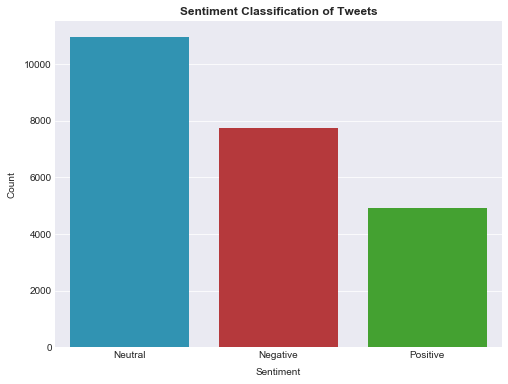

In [50]:
tweets_all_months.plot_sentiment(figsize=(8, 6))

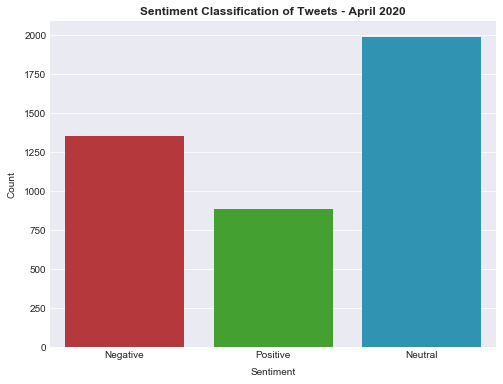

In [41]:
# April
tweets_all_months.plot_sentiment(sentiment_month=4, year=2020, figsize=(8, 6))

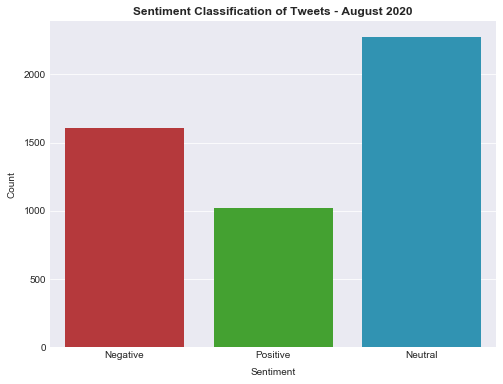

In [42]:
# August
tweets_all_months.plot_sentiment(sentiment_month=8, year=2020, figsize=(8, 6))

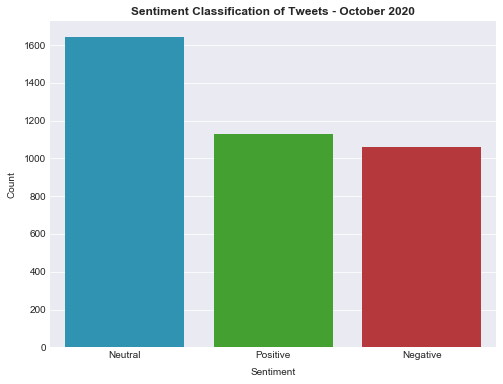

In [43]:
# October
tweets_all_months.plot_sentiment(sentiment_month=10, year=2020, figsize=(8, 6))